In [1]:
"""Temporary fix for importing modules from parent directory"""
import os
import sys

module_path = os.path.abspath(os.path.join(".."))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
from varitop.integrator import DelIntegrator as DI
from matplotlib import pyplot as plt
from tqdm import tqdm

from varitop.problem import VaritopProblem
from varitop.misc import euler_rule, skew_quaternion, qconj

import casadi as cs
import numpy as np

Matplotlib created a temporary cache directory at /tmp/matplotlib-01r5gxq8 because the default path (/home/mambauser/.config/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [3]:
def w(q, dq):
    return 2 * skew_quaternion(qconj(q)) @ dq

# Problem Definition

Scalar-first quaternion dynamics.


In [4]:
q_0 = np.array([1.0, 0.0, 0.0, 0.0])
I = np.diag([0.0, 1.0, 1.0, 1.0])
l = 1.0
Kt = 1
Km = 1

In [5]:
K = cs.vcat(
    [
        cs.hcat([0, l * Kt, 0, -l * Kt]),
        cs.hcat([-l * Kt, 0, l * Kt, 0]),
        cs.hcat([Km, -Km, Km, -Km]),
    ]
)

In [6]:
t0, tf, steps = 0.0, 3.0, 200
dt = (tf - t0) / steps

In [7]:
problem = VaritopProblem()
problem.nodes = steps
problem.nq = 4
problem.nv = 4
problem.nu = 4

In [8]:
qs = problem.state
vs = problem.velocity
us = problem.control
q, v, u = qs[0], vs[0], us[0]

In [10]:
# PE = 0 => KE = L = TE
kinetic = cs.Function("kinetic", [q, v], [0.5 * w(q, v).T @ I @ w(q, v)])
# Constraint on unit quaternion
phi0 = cs.Function("phi0", [q], [qconj(q).T @ q - 1])
# force
f = cs.Function("f", [q, v, u], [cs.vertcat(0, K @ u)])

In [13]:
problem.dynamics = kinetic
problem.rule = euler_rule
problem.free = True  # quaternion dynamics
problem.integrator = DI
problem.add_dynamics_constraints([phi0])
problem.add_forces([f])

In [14]:
residual = problem.integrator.step()
residual

Function(del:(q-1[4],q[4],q+1[4],dt,lambda,u[4])->(DEL Residual[5]) SXFunction)

In [15]:
def build_rf_problem(prob: VaritopProblem):
    """Reorder arguments to match rootfinder signature"""
    res = prob.integrator.step()
    nq = prob.nq
    nv = prob.nv
    nu = prob.nu

    q0 = cs.SX.sym("q", nq)
    q1 = cs.SX.sym("q", nq)
    q2 = cs.SX.sym("q", nq)
    dt = cs.SX.sym("dt")
    lambdas = cs.SX.sym("lambda", 1)
    u = cs.SX.sym("u", nu)

    x = cs.vertcat(q2, lambdas)
    rfr = cs.Function("rfr", [x, q0, q1, dt, u], [res(q0, q1, q2, dt, lambdas, u)])
    rf = cs.rootfinder("rf", "newton", rfr)
    return rf

In [16]:
rf = build_rf_problem(problem)
rf

Function(rf:(i0[5],i1[4],i2[4],i3,i4[4])->(o0[5]) Newton)

# Integration


In [43]:
qs_sol = np.zeros((steps, 4))
qs_sol[0] = q_0
qs_sol[1] = q_0
us_sol = np.full((steps, 4), np.array([1, 0, -1, 0]))
ke = np.zeros(steps)
ws = np.zeros((steps, 4))
dqs = np.zeros((steps, 4))

for i in tqdm(range(2, steps)):
    q0 = qs_sol[i - 2]
    q1 = qs_sol[i - 1]
    guess = np.hstack([q1, np.zeros(1)])
    qs_sol[i] = np.array(rf(guess, q0, q1, dt, us_sol[i]))[:4].ravel()
    dq = (qs_sol[i] - qs_sol[i - 1]) / dt
    dqs[i] = dq

for i in range(steps):
    q = qs_sol[i]
    dq = dqs[i]
    ws[i] = np.array(w(q, dq)).ravel()
    ke[i] = kinetic(q, dq)

100%|██████████| 198/198 [00:00<00:00, 3992.67it/s]


In [44]:
import numpy as np


def quaternion_to_rotation_matrix(q):
    q = np.array(q)
    q /= np.linalg.norm(q)
    w, x, y, z = q

    rotation_matrix = np.array(
        [
            [1 - 2 * y**2 - 2 * z**2, 2 * x * y - 2 * w * z, 2 * x * z + 2 * w * y],
            [2 * x * y + 2 * w * z, 1 - 2 * x**2 - 2 * z**2, 2 * y * z - 2 * w * x],
            [2 * x * z - 2 * w * y, 2 * y * z + 2 * w * x, 1 - 2 * x**2 - 2 * y**2],
        ]
    )

    return rotation_matrix

In [45]:
basis_vectors = np.array([[1, 0, 0], [0, 1, 0], [0, 0, 1]])
rms = np.array([quaternion_to_rotation_matrix(q) for q in qs_sol])

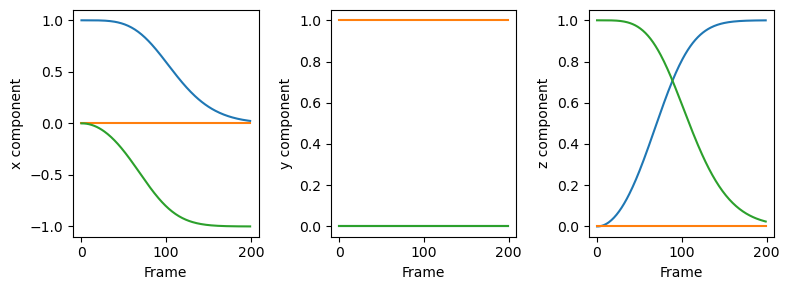

In [46]:
import matplotlib.pyplot as plt

# Extract the x, y, z components of the basis vectors
x = rms[:, 0]
y = rms[:, 1]
z = rms[:, 2]

# Create three separate plots for x, y, z components
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(8, 3))

# Plot x component
ax1.plot(x)
ax1.set_xlabel("Frame")
ax1.set_ylabel("x component")

# Plot y component
ax2.plot(y)
ax2.set_xlabel("Frame")
ax2.set_ylabel("y component")

# Plot z component
ax3.plot(z)
ax3.set_xlabel("Frame")
ax3.set_ylabel("z component")

# Display the plots
plt.tight_layout()
plt.show()

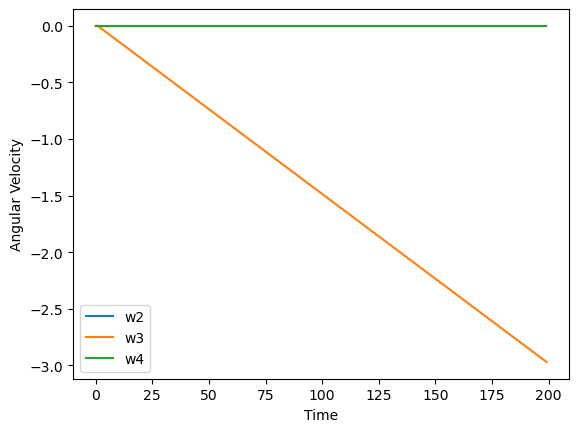

In [49]:
import matplotlib.pyplot as plt


# Plot the components of ws
# plt.plot(ws[:, 0], label="w1")
plt.plot(ws[:, 1], label="w2")
plt.plot(ws[:, 2], label="w3")
plt.plot(ws[:, 3], label="w4")

# Add labels and legend
plt.xlabel("Time")
plt.ylabel("Angular Velocity")
plt.legend()

# Display the plot
plt.show()

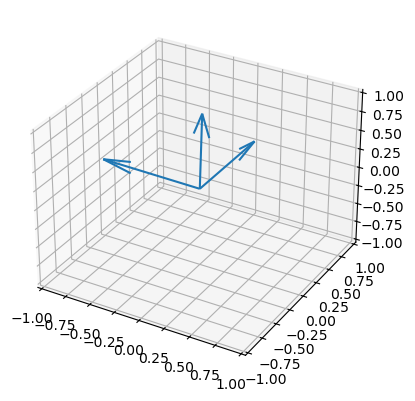

In [48]:
from matplotlib.animation import FuncAnimation

fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")

ax.set_xlim(-1, 1)
ax.set_ylim(-1, 1)
ax.set_zlim(-1, 1)

basis = ax.quiver(0, 0, 0, basis_vectors[0], basis_vectors[1], basis_vectors[2])


def update(frame):
    # Rotate the basis vectors
    rotated_vectors = rms[frame] @ basis_vectors.T

    global basis
    basis.remove()
    basis = ax.quiver(
        0, 0, 0, rotated_vectors[0], rotated_vectors[1], rotated_vectors[2]
    )


# Create the animation
animation = FuncAnimation(fig, update, frames=len(qs_sol), interval=tf * 1000 / steps)

# Save the animation as a GIF using Pillow writer
animation.save("evolution_history.gif")

# Display the animation
plt.show()